<a href="https://colab.research.google.com/github/yuhengUA2077/EECE5354_TLearning/blob/main/Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>EECE 5354: Computer Vision Spring 2022<br>
Homework 6: Transfer Learning with Pretrained Convolutional Neural Nets</center></h1>
<hr>

### <center>Yuheng Shi<center>

<h2>1. Import Packages</h2>

The two cells below connect this Colab notebook to my Google drive and import necessary packages and libraries used in this assignment.

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

import os
os.chdir('/content/gdrive/MyDrive/TLearn')
%ls

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
cats_dogs_basic_cnn.h5                    model_evaluation_utils.py
cats_dogs_cnn_img_aug.h5                  __pycache__/
cats_dogs_first_cnn.h5                    test_data/
cats_dogs_tlearn_basic_cnn.h5             train/
cats_dogs_tlearn_finetune_img_aug_cnn.h5  training_data/
cats_dogs_tlearn_img_aug_cnn.h5           validation_data/


In [ ]:
# Import the necessary libraries and functions
#
# The glob module finds all the pathnames matching a specified
# pattern according to the rules used by the Unix shell
import glob
# provides a portable way of using operating system dependent functionality
import os
# high-level operations on files and collections of files.
import shutil
# Open source data analysis and manipulation tool, built on top of the Python
import pandas as pd
# Numerical library for linear algebra and Fourier analysis
import numpy as np
# Library for creating visualizations in Python
import matplotlib.pyplot as plt
# Computational engine for ANNs and other ML functions
import tensorflow as tf
# Front end scripting library for tensorflow and other back ends
from tensorflow import keras
# keras routines that are part of tensorflow
# points to pretrained vgg-16 model in cloud
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model  # of the ANN
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer
# NN with a simple stack of feed forward layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# scikit-learn has tools for predictive data analysis
from sklearn.preprocessing import LabelEncoder

<h2>2. Preparing Datasets</h2>

I downloaded the dataset and created folders for training data, validation data, and testing data. 1500 images for training are randomly chosen for Cat category and another 1500 for Dog category. For validation images, 500 files are randomly chosen from the remaining images for each category. The same procedure was performed for testing images. The images are saved in separate folders and each image is unique and no identical image appears twice in different folders.


In [ ]:
'''
Script 0: load_data.py

This file creates training datasets, validation datasets, and testing datasets 
from the overall image datasets randomly. For each category, 1500 images are 
chosen as the training set, 500 images are chosen for the validation set, and 
another 500 images are for testing. Three datasets are all independent and unique. 
The images are saved in three different folders for later use. 

'''

# set seed to make the result predictable (always the same)
np.random.seed(42)
# all pictures in train folder
files = glob.glob('train/*')

# classified images into cats and dogs
cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)  # (12500, 12500)
# randomly select 1500 images for each category as training set
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
# randomly select 500 images in the remaining images for each category as validate set
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))
cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
# randomly select 500 images in the remaining images for each category as test set
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))
cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)  # (1500,) (500,) (500,)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)  # (1500,) (500,) (500,)


Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [ ]:
# define folders
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'
# define training sets, validate sets, and test sets
train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

# prevent random files to be copied into different folders
# os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
print('copying training files to', train_dir)
for fn in train_files:
    shutil.copy(fn, train_dir)
# os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
print('copying validation files to', val_dir)
for fn in validate_files:
    shutil.copy(fn, val_dir)
# os.mkdir(test_dir) if not os.path.isdir(test_dir) else None
print('copying testing files to', test_dir)
for fn in test_files:
    shutil.copy(fn, test_dir)

copying training files to training_data
copying validation files to validation_data
copying testing files to test_data


<h2>3. Simple CNN Model from Scratch</h2>

The size of every image is (150, 150) with three color channels representing RGB. The labels for training images and validation images were created and encoded into integers (Cat is 0 and Dog is 1). The pixel-level of images was scaled down to (0,1) since it’s easier for the network to compute. The basic configuration parameters were initialized by following the tutorial. After the layers of the model is provided, the CNN model was trained for a total of 30 epochs with 30 images each epoch. 1000 validation images were used to verify the result. The figure below shows that the model was overfitted and the accuracy is about 70%.

In [ ]:
'''
Script 1: cnn_1.py

This file creates a simple CNN from the scratch. This CNN consists of three 
convolution layers, coupled with max-pooling for feature extraction. The outputs 
from the convolution layer are flattened and passed to a fully connected layer 
for final classification. The model was trained for a total of 30 epochs with 30 
images for each epoch. 1000 validation images were used to verify the result. 
The result on training data was quite good, reaching 100% after 10 epochs. 
The accuracy for validation data was about 70% but the model starts overfitting 
which needs further adjustments.

'''

# image size is (150, 150)
IMG_DIM = (150, 150)
# store all training images to numpy array
train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
# store all training image labels
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]
# store all validation images to numpy array
validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
# store all validating image labels
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]
# Each image is of size 150 x 150 and has three channels for RGB
print('Train dataset shape:', train_imgs.shape,
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (2903, 150, 150, 3)


(150, 150, 3)


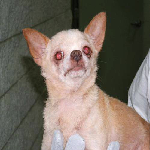

In [ ]:
# change the type to float
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
# scale each image with pixel values between (0, 255) to values between (0, 1)
train_imgs_scaled /= 255
validation_imgs_scaled /= 255
# print the shape of image
print(train_imgs[0].shape)
# display one image
array_to_img(train_imgs[0])

In [ ]:
# set up basic configuration parameters
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

# encode text class labels into numeric values for both training data and validation data
le = LabelEncoder()
le.fit(train_labels)
# cat is 0 and dog is 1
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog'] [0 0 0 0 0 1 1 1 1 1]


In [ ]:
# the model starts with Sequential()
# Sequential groups a linear stack of layers into a complete model
model = Sequential()
# add a convolutional layer with 16 filters and ReLU activation function
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu',
                 input_shape=input_shape))
# use Max Pooling to reduce the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2, 2)))
# add a convolutional layer with 64 filters and ReLU activation function
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# use Max Pooling to reduce the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2, 2)))
# add a convolutional layer with 128 filters and ReLU activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# use Max Pooling to reduce the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2, 2)))
# flatten the output without changing the batch size
model.add(Flatten())
# add a densely-connected NN layer to connect all the layer above
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# configure the model with losses and metrics
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])
# Prints a string summary of the network
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

Particularly in this run, the validation accuracy is about 72%. It can be clearly seen that there was a large gap on epoch 4 and the model was overfitted after that epoch.

Epoch 1/30
100/100 [==============================] - 4s 28ms/step - loss: 0.8759 - accuracy: 0.5497 - val_loss: 0.6679 - val_accuracy: 0.6400
Epoch 2/30
100/100 [==============================] - 2s 24ms/step - loss: 0.6449 - accuracy: 0.6443 - val_loss: 0.7728 - val_accuracy: 0.5939
Epoch 3/30
100/100 [==============================] - 2s 24ms/step - loss: 0.5623 - accuracy: 0.7173 - val_loss: 0.6627 - val_accuracy: 0.6996
Epoch 4/30
100/100 [==============================] - 2s 24ms/step - loss: 0.4901 - accuracy: 0.7673 - val_loss: 0.7084 - val_accuracy: 0.6200
Epoch 5/30
100/100 [==============================] - 2s 24ms/step - loss: 0.4067 - accuracy: 0.8067 - val_loss: 0.5655 - val_accuracy: 0.7354
Epoch 6/30
100/100 [==============================] - 2s 24ms/step - loss: 0.3157 - accuracy: 0.8670 - val_loss: 0.6203 - val_accuracy: 0.7420
Epoch 7/30
100/100 [==============================] - 2s 24ms/step - loss: 0.2351 - accuracy: 0.9057 - val_loss: 0.7110 - val_accuracy: 0.7282

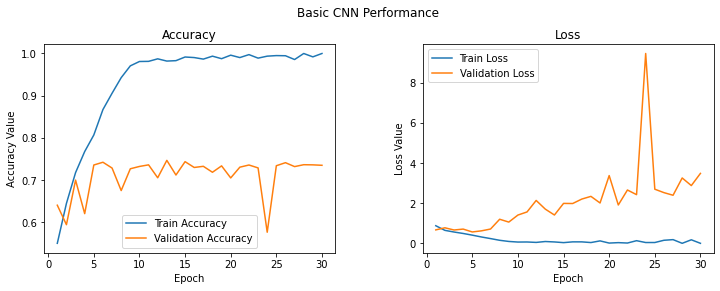

In [ ]:
# Trains the model for a fixed number of epochs (iterations on a dataset)
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
# create 1x2 subplot to show the accuracy adn loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
# first plot: training accuracy and validation accuracy
epoch_list = list(range(1, 31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
# second plot: training loss and validation loss
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# save the trained model for later use
model.save('cats_dogs_first_cnn.h5')

## 4. CNN Model with Regularization
To improve the performance, one more convolution layer and another dense hidden layer were implemented in the model. Besides, 30% of outputs were randomly dropped out after each hidden dense layer to enable regularization. The figure below demonstrates the model performance after the changes to the model were made. The plot shows that the model was still overfitted, but the accuracy increased to about 75%.


In [ ]:
'''
Script 2: cnn_2.py

This file creates a basic CNN with improvements on the first simple CNN. 
This CNN consists of four convolution layers, coupled with max-pooling for 
feature extraction. An additional fully connected Dense layer is implemented 
as well. Besides, 30% of outputs were randomly dropped out after each hidden 
dense layer to enable regularization. The model was trained for a total of 30 
epochs with 30 images for each epoch. 1000 validation images were used to 
verify the result. This basic CNN model was still overfitted, but the accuracy 
increased to about 75%.

'''

# the model starts with Sequential()
# Sequential groups a linear stack of layers into a complete model
model = Sequential()
# add a convolutional layer with 16 filters and ReLU activation function
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu',
                 input_shape=input_shape))
# use Max Pooling to reduce the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2, 2)))
# add a convolutional layer with 64 filters and ReLU activation function
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# use Max Pooling to reduce the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2, 2)))
# add a convolutional layer with 128 filters and ReLU activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# use Max Pooling to reduce the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2, 2)))
# add a convolutional layer with 128 filters and ReLU activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# use Max Pooling to reduce the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2, 2)))
# flatten the output without changing the batch size
model.add(Flatten())
# add a dense layer to connect all the layer with ReLU
model.add(Dense(512, activation='relu'))
# randomly masks the outputs of 30% units from a layer by setting their output to zero
model.add(Dropout(0.3))
# add a dense layer to connect all the layer with ReLU
model.add(Dense(512, activation='relu'))
# randomly masks the outputs of 30% units from a layer by setting their output to zero
model.add(Dropout(0.3))
# add a dense layer to connect all the layer with sigmoid
model.add(Dense(1, activation='sigmoid'))
# configure the model with losses and metrics
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])
# Prints a string summary of the network
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 128)     

Epoch 1/30
100/100 [==============================] - 4s 26ms/step - loss: 0.7013 - accuracy: 0.5283 - val_loss: 0.6692 - val_accuracy: 0.6163
Epoch 2/30
100/100 [==============================] - 2s 21ms/step - loss: 0.6648 - accuracy: 0.6133 - val_loss: 0.6224 - val_accuracy: 0.6428
Epoch 3/30
100/100 [==============================] - 2s 21ms/step - loss: 0.6032 - accuracy: 0.6860 - val_loss: 0.5857 - val_accuracy: 0.7013
Epoch 4/30
100/100 [==============================] - 2s 20ms/step - loss: 0.5434 - accuracy: 0.7353 - val_loss: 0.5627 - val_accuracy: 0.7158
Epoch 5/30
100/100 [==============================] - 2s 21ms/step - loss: 0.5150 - accuracy: 0.7557 - val_loss: 0.5223 - val_accuracy: 0.7485
Epoch 6/30
100/100 [==============================] - 2s 21ms/step - loss: 0.4642 - accuracy: 0.7833 - val_loss: 0.5397 - val_accuracy: 0.7241
Epoch 7/30
100/100 [==============================] - 2s 21ms/step - loss: 0.4128 - accuracy: 0.8137 - val_loss: 0.5517 - val_accuracy: 0.7578

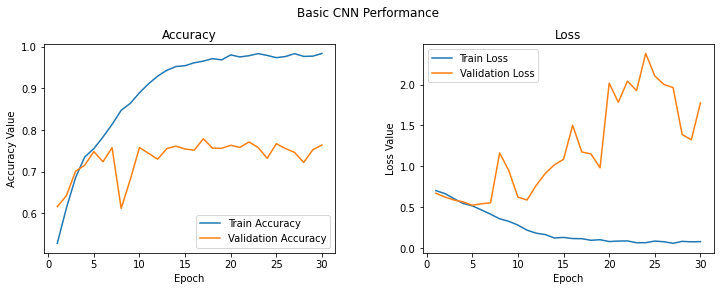

In [ ]:
# Trains the model for a fixed number of epochs (iterations on a dataset)
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
# create 1x2 subplot to show the accuracy and loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
# first plot: training accuracy and validation accuracy
epoch_list = list(range(1, 31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
# second plot: training loss and validation loss
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# save the trained model for later use
model.save('cats_dogs_basic_cnn.h5')

## 5. CNN Model with Image Augmentation
Since the outcome of the regularization was not promising enough, image augmentation was introduced. The idea of image augmentation is to produce more altered versions of images from existing images by applying transformation operations such as rotation, translation, shearing, and zooming on them. ImageDataGenerator was used to feed those new images to the model during the training process. Fig.3 demonstrates the generated images with image augmentation. In this part, the CNN model was trained for a total of 100 epochs with 30 images each epoch. After the model was trained, the performance was shown in the figure below. The plot shows that the model was no longer overfitted and the accuracy increased to about 82%.


In [ ]:
'''
Script 3: cnn_3.py

This file creates a CNN with image augmentations. The architecture of the CNN 
is identical to the basic CNN created in the cnn_2.py file. Image augmentation 
was introduced to generate more altered images to achieve better training. The 
model was trained for a total of 100 epochs with 30 images for each epoch. 1000 
validation images were used to verify the result, and image augmentations were 
only applied to training images. This CNN model has the better performance with 
a validation accuracy of 82% while the overfitting problem was solved.

'''

# encode text class labels into numeric values for both training data and validation data
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)
# initialize two data generators and set parameters for transformations
train_datagen = ImageDataGenerator(rescale=1. / 255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1. / 255)
# loads the training image dataset in memory and generates batches of augmented data
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
# loads the validation image dataset in memory and generates batches of augmented data
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)
input_shape = (150, 150, 3)

In [ ]:
# the model starts with Sequential()
# Sequential groups a linear stack of layers into a complete model
model = Sequential()
# add a convolutional layer with 16 filters and ReLU activation function
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu',
                 input_shape=input_shape))
# use Max Pooling to reduce the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2, 2)))
# add a convolutional layer with 64 filters and ReLU activation function
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# use Max Pooling to reduce the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2, 2)))
# add a convolutional layer with 128 filters and ReLU activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# use Max Pooling to reduce the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2, 2)))
# add a convolutional layer with 128 filters and ReLU activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# use Max Pooling to reduce the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2, 2)))
# flatten the output without changing the batch size
model.add(Flatten())
# add a dense layer to connect all the layer with ReLU
model.add(Dense(512, activation='relu'))
# randomly masks the outputs of 30% units from a layer by setting their output to zero
model.add(Dropout(0.3))
# add a dense layer to connect all the layer with ReLU
model.add(Dense(512, activation='relu'))
# randomly masks the outputs of 30% units from a layer by setting their output to zero
model.add(Dropout(0.3))
# add a dense layer to connect all the layer with sigmoid
model.add(Dense(1, activation='sigmoid'))
# configure the model with losses and metrics
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])
# Prints a string summary of the network
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 17, 17, 128)    

Epoch 1/100
100/100 [==============================] - 17s 155ms/step - loss: 0.6929 - accuracy: 0.5137 - val_loss: 0.6977 - val_accuracy: 0.4960
Epoch 2/100
100/100 [==============================] - 15s 153ms/step - loss: 0.6908 - accuracy: 0.5273 - val_loss: 0.6957 - val_accuracy: 0.4930
Epoch 3/100
100/100 [==============================] - 15s 154ms/step - loss: 0.6732 - accuracy: 0.5807 - val_loss: 0.7056 - val_accuracy: 0.5250
Epoch 4/100
100/100 [==============================] - 15s 154ms/step - loss: 0.6655 - accuracy: 0.5957 - val_loss: 0.6528 - val_accuracy: 0.6190
Epoch 5/100
100/100 [==============================] - 15s 153ms/step - loss: 0.6551 - accuracy: 0.6070 - val_loss: 0.6230 - val_accuracy: 0.6550
Epoch 6/100
100/100 [==============================] - 15s 154ms/step - loss: 0.6433 - accuracy: 0.6227 - val_loss: 0.6193 - val_accuracy: 0.6430
Epoch 7/100
100/100 [==============================] - 15s 155ms/step - loss: 0.6422 - accuracy: 0.6250 - val_loss: 0.6027 -

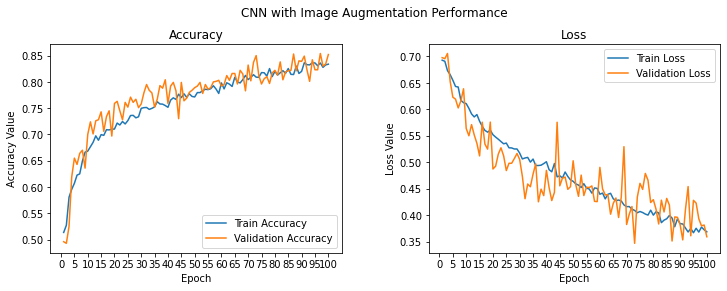

In [ ]:
# Trains the model for a fixed number of epochs (iterations on a dataset)
history = model.fit(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50,
                              verbose=1)
# create 1x2 subplot to show the accuracy and loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
# first plot: training accuracy and validation accuracy
epoch_list = list(range(1, 101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
# second plot: training loss and validation loss
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
# demonstrate the plots
plt.show()
# save the trained model for later use
model.save('cats_dogs_cnn_img_aug.h5')

## 6. Pre-trained CNN model as a Feature Extractor
To create a better model via transfer learning, VGG-16 model was imported as the pre-trained model. The convolution layers of the model were set as frozen to avoid changing their weights when training the model. The cell below imports the VGG-16 model and demonstrates the frozen layers of the pre-trained model. The figure below demonstrates the bottleneck features of pre-trained VGG-16 model.



In [ ]:
'''
Script 4: tl_1.py

This file creates a neural model with a pre-trained VGG-16 model as the feature extractor. 
The pre-trained model was imported and we flattened the bottleneck features to pass them 
to the fully connected layers. Besides, 30% of outputs were randomly dropped out after 
each hidden dense layer to enable regularization. The model was trained for a total of 
30 epochs with 30 images for each epoch. 1000 validation images were used to verify the 
result. The validation accuracy increased to 87.5% but the overfitting problem occurred again.

'''

# load up VGG-16 model
vgg = vgg16.VGG16(include_top=False, weights='imagenet',
                  input_shape=input_shape)
# Stacking a new Flatten layer on top of it
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
# generate a new model
vgg_model = Model(vgg.input, output)
# freeze all convolution layers
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
# display all the layers in the model and check if they are all frozen
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f5894686190>,input_7,False
1,<keras.layers.convolutional.Conv2D object at 0x7f5895c75790>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f58969ad2d0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f58946a2050>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f58946e7990>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f5895d5b4d0>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f58968288d0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f5896990250>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f589698ced0>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f58946cfad0>,block3_conv3,False


(1, 4, 4, 512)


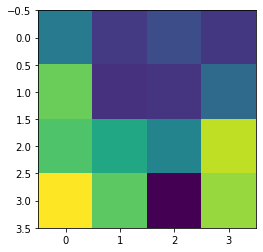

In [ ]:
# visualize bottleneck features for one sample image
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:, :, 0])

In [ ]:
# define a function to extract bottleneck features
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features


# extract out all the features from training datasets
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
# extract out all the features from training datasets
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape,
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)
# get the output shape so that we can add layer after it with proper size
input_shape = vgg_model.output_shape[1]

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (2903, 8192)


The bottleneck features were used to extract the features from our training images and validation images, and those features are fed to the fully connected classifier (Dense layers and Dropouts). After the classifier was added and the features were taken as inputs, the model was trained by 30 iterations with 30 images each. The number of validation images was still 1000. The performance plot was shown in the figure below. The plot shows that the model accuracy has increased to about 87.5% compared to the previous model from scratch, but the model was overfitted.

In [ ]:
# the model starts with Sequential()
# Sequential groups a linear stack of layers into a complete model
model = Sequential()
# add an input layer to connect pre-trained model
model.add(InputLayer(input_shape=(input_shape,)))
# add a dense layer to connect all the layer with ReLU, specify the dimension to match the input layer
model.add(Dense(512, activation='relu', input_dim=input_shape))
# randomly masks the outputs of 30% units from a layer by setting their output to zero
model.add(Dropout(0.3))
# add a dense layer to connect all the layer with ReLU
model.add(Dense(512, activation='relu'))
# randomly masks the outputs of 30% units from a layer by setting their output to zero
model.add(Dropout(0.3))
# add a dense layer to connect all the layer with sigmoid
model.add(Dense(1, activation='sigmoid'))
# configure the model with losses and metrics
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])
# Prints a string summary of the network
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
100/100 [==============================] - 1s 8ms/step - loss: 0.4540 - accuracy: 0.7847 - val_loss: 0.2996 - val_accuracy: 0.8684
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2935 - accuracy: 0.8697 - val_loss: 0.2978 - val_accuracy: 0.8753
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2326 - accuracy: 0.9047 - val_loss: 0.3024 - val_accuracy: 0.8801
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2108 - accuracy: 0.9157 - val_loss: 0.2552 - val_accuracy: 0.8991
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.1722 - accuracy: 0.9277 - val_loss: 0.2728 - val_accuracy: 0.8929
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.1550 - accuracy: 0.9330 - val_loss: 0.2770 - val_accuracy: 0.8942
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.1209 - accuracy: 0.9510 - val_loss: 0.3040 - val_accuracy: 0.8973
Epoch 

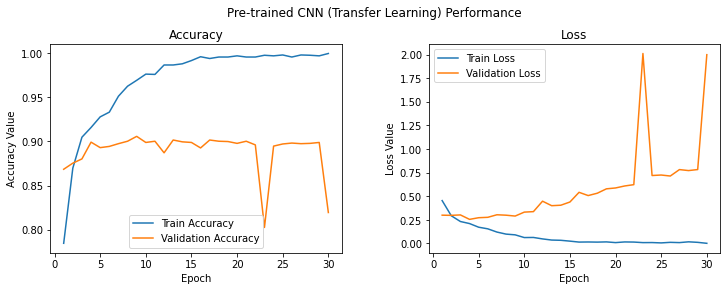

In [ ]:
# Trains the model for a fixed number of epochs (iterations on a dataset)
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
# create 1x2 subplot to show the accuracy and loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
# first plot: training accuracy and validation accuracy
epoch_list = list(range(1, 31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
# second plot: training loss and validation loss
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# save the trained model for later use
model.save('cats_dogs_tlearn_basic_cnn.h5')

## 7. Pre-trained CNN model as a Feature Extractor with Image Augmentation
Similar to Part D above, ImageDataGenerator is used to create altered versions of existing images. Since the bottleneck features were not extracted for training purposes this time, the vgg_model object was directly passed as an input to the fully connected classifier. The model was trained for 100 epochs. The figure below demonstrates the performance of the modified model. It shows that the validation accuracy of the model has increased to 90% and the overfitting issue is solved.


In [ ]:
'''
Script 5: tl_2.py

This file creates a neural model with a pre-trained VGG-16 model as the feature 
extractor, and image augmentation was included. The architecture of the model is 
identical to the previous model created in the tl_1.py file. The bottleneck 
features were not extracted for training purposes this time. The model was trained 
for a total of 100 epochs with 30 images for each epoch. 1000 validation images 
were used to verify the result. The validation accuracy increased to 90% and the 
overfitting problem was resolved.

'''

# initialize two data generators and set parameters for transformations
train_datagen = ImageDataGenerator(rescale=1. / 255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')
# Generate batches of validation image data with real-time data augmentation
val_datagen = ImageDataGenerator(rescale=1. / 255)
# loads the training image dataset in memory and generates batches of augmented data
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
# loads the validation image dataset in memory and generates batches of augmented data
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [ ]:
# the model starts with Sequential()
# Sequential groups a linear stack of layers into a complete model
model = Sequential()
# start with new created vgg model
model.add(vgg_model)
# add a dense layer to connect all the layer with ReLU, specify the dimension to match the input layer
model.add(Dense(512, activation='relu', input_dim=input_shape))
# randomly masks the outputs of 30% units from a layer by setting their output to zero
model.add(Dropout(0.3))
# add a dense layer to connect all the layer with ReLU
model.add(Dense(512, activation='relu'))
# randomly masks the outputs of 30% units from a layer by setting their output to zero
model.add(Dropout(0.3))
# add a dense layer to connect all the layer with sigmoid
model.add(Dense(1, activation='sigmoid'))
# configure the model with losses and metrics
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])
# Prints a string summary of the network
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 8192)              14714688  
                                                                 
 dense_31 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 512)               262656    
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 1)                 513       
                                                                 
Total params: 19,172,673
Trainable params: 4,457,985


Epoch 1/100
100/100 [==============================] - 19s 179ms/step - loss: 0.6667 - accuracy: 0.6000 - val_loss: 0.4842 - val_accuracy: 0.8320
Epoch 2/100
100/100 [==============================] - 19s 188ms/step - loss: 0.5600 - accuracy: 0.7077 - val_loss: 0.3944 - val_accuracy: 0.8420
Epoch 3/100
100/100 [==============================] - 18s 180ms/step - loss: 0.5180 - accuracy: 0.7367 - val_loss: 0.3604 - val_accuracy: 0.8610
Epoch 4/100
100/100 [==============================] - 18s 176ms/step - loss: 0.4814 - accuracy: 0.7757 - val_loss: 0.3600 - val_accuracy: 0.8510
Epoch 5/100
100/100 [==============================] - 18s 175ms/step - loss: 0.4632 - accuracy: 0.7757 - val_loss: 0.3364 - val_accuracy: 0.8610
Epoch 6/100
100/100 [==============================] - 18s 176ms/step - loss: 0.4438 - accuracy: 0.7867 - val_loss: 0.3044 - val_accuracy: 0.8730
Epoch 7/100
100/100 [==============================] - 18s 176ms/step - loss: 0.4234 - accuracy: 0.8047 - val_loss: 0.3071 -

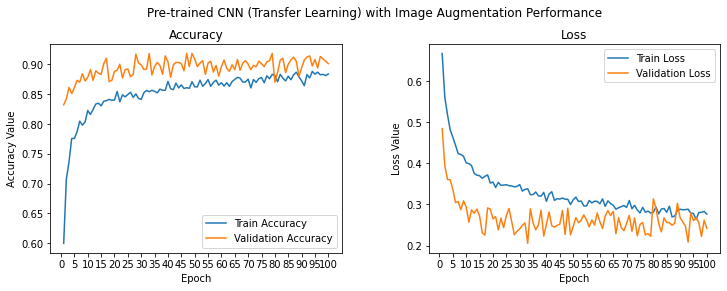

In [ ]:
# Trains the model for a fixed number of epochs (iterations on a dataset)
history = model.fit(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50,
                              verbose=1)
# create 1x2 subplot to show the accuracy and loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
# first plot: training accuracy and validation accuracy
epoch_list = list(range(1, 101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
# second plot: training loss and validation loss
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# save the trained model for later use
model.save('cats_dogs_tlearn_img_aug_cnn.h5')

## 8. Pre-trained CNN model with Fine-Tuning and Image Augmentation

In this part, the convolution block 4 and 5 of the VGG-16 model was set as unfreeze during the training process while leaving other blocks unchanged. This indicates that the weight of layers in blocks 4 and 5 will be updated with backpropagation in each iteration. The other parts of the model were the same as in the previous part. The performance of the fine-tuned model is shown in Fig.8. As can be seen in the figure, the model accuracy is further improved to 95%~96%. However, slight overfitting of the model can be observed in the figure.


In [ ]:
'''
Script 6: tl_3.py

This file creates a neural model with a pre-trained VGG-16 model, and image 
augmentation was included. The fine-tuning strategy was used instead of using 
the pre-trained model only as a feature extractor. The model unfreezes the 
convolution blocks 4 and 5, enabling them to adjust weight during the training 
phase. The remaining architecture of the model is identical to the previous 
model created in the tl_1.py file. The model was trained for a total of 100 
epochs with 30 images for each epoch. 1000 validation images were used to 
verify the result. The validation accuracy of the model is further improved 
to 95%~96% but the overfitting problem can be slightly seen in the result.

'''

# load up VGG-16 model
input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet',input_shape=input_shape)
# Stacking a new Flatten layer on top of it
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
# generate a new model
vgg_model.trainable = True
# freeze all convolution layers except convolution blocks 4 and 5
set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
# display all the layers in the model and check if they are all frozen
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])
# initialize two data generators and set parameters for transformations
train_datagen = ImageDataGenerator(rescale=1. / 255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1. / 255)
# loads the training image dataset in memory and generates batches of augmented data
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
# loads the validation image dataset in memory and generates batches of augmented data
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [ ]:
# the model starts with Sequential()
# Sequential groups a linear stack of layers into a complete model
model = Sequential()
# start with new created vgg model
model.add(vgg_model)
# add a dense layer to connect all the layer with ReLU, specify the dimension to match the input layer
model.add(Dense(512, activation='relu', input_dim=input_shape))
# randomly masks the outputs of 30% units from a layer by setting their output to zero
model.add(Dropout(0.3))
# add a dense layer to connect all the layer with ReLU
model.add(Dense(512, activation='relu'))
# randomly masks the outputs of 30% units from a layer by setting their output to zero
model.add(Dropout(0.3))
# add a dense layer to connect all the layer with sigmoid
model.add(Dense(1, activation='sigmoid'))
# configure the model with losses and metrics
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])
# Prints a string summary of the network
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_5 (Functional)        (None, 8192)              14714688  
                                                                 
 dense_34 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 512)               262656    
                                                                 
 dropout_21 (Dropout)        (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 1)                 513       
                                                                 
Total params: 19,172,673
Trainable params: 17,437,185

Epoch 1/100
100/100 [==============================] - 19s 175ms/step - loss: 0.6145 - accuracy: 0.6443 - val_loss: 0.3831 - val_accuracy: 0.8480
Epoch 2/100
100/100 [==============================] - 17s 172ms/step - loss: 0.4248 - accuracy: 0.8047 - val_loss: 0.2295 - val_accuracy: 0.9000
Epoch 3/100
100/100 [==============================] - 17s 171ms/step - loss: 0.3299 - accuracy: 0.8613 - val_loss: 0.1960 - val_accuracy: 0.9120
Epoch 4/100
100/100 [==============================] - 18s 175ms/step - loss: 0.3115 - accuracy: 0.8667 - val_loss: 0.2049 - val_accuracy: 0.9170
Epoch 5/100
100/100 [==============================] - 17s 169ms/step - loss: 0.2581 - accuracy: 0.8907 - val_loss: 0.1466 - val_accuracy: 0.9370
Epoch 6/100
100/100 [==============================] - 17s 170ms/step - loss: 0.2429 - accuracy: 0.9027 - val_loss: 0.1703 - val_accuracy: 0.9250
Epoch 7/100
100/100 [==============================] - 17s 170ms/step - loss: 0.2249 - accuracy: 0.9050 - val_loss: 0.1407 -

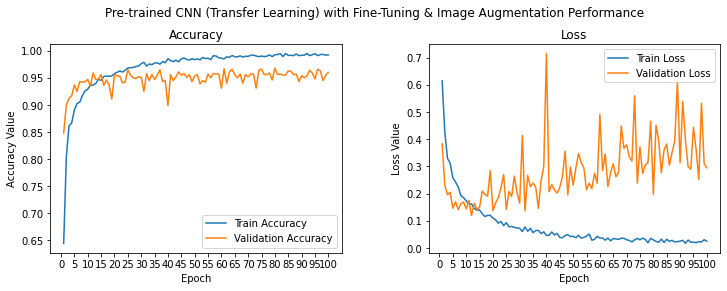

In [ ]:
# Trains the model for a fixed number of epochs (iterations on a dataset)
history = model.fit(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50,
                              verbose=1)
# create 1x2 subplot to show the accuracy and loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
# first plot: training accuracy and validation accuracy
epoch_list = list(range(1, 101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
# second plot: training loss and validation loss
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# save the trained model for later use
model.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

## 9. Evaluating our Deep Learning Models on Test Data

In this part, we evaluate the overall performance of all the models created in the previous parts. A python file “*model_evaluation_utils.py*” is imported for the visualization of performance metrics. We read all the models saved in the same directory and use them to make predictions on the testing dataset. The accuracy of the predictions by each model is evaluated by the performance metrics (such as F1-score) report and ROC curve plots. The F1 score takes false positives and false negatives to test the precision of the predictions. The ROC curve is also a performance criterion to analyze the binary classification model. If the area under the ROC curve is larger, in other words, closer to 1, the model has a better performance on classifications. From the report below, we observe that every subsequent model has better performance than the previous model. The first simple CNN model has the lowest accuracy and F1 score of 74% and the fine-tuning pre-trained model has the highest accuracy and F1 score of 95%. The ROC curves demonstrate the results that are consistent with the F1 score.

In [ ]:
'''
Script 7: evaluation.py

This file is used to evaluate the six models created and stored by previous scripts. 
An additional python module called ''model_evaluation_utils'' is used to check the
performance of models and generate ROC curves. From the table report generated, we 
observe that the F1-score of the model increases from 74 to 95. The area below the 
ROC curve is closer to 1 when more advanced improvements are applied to the neural 
networks and higher performance is achieved.

'''

# import load_model method
from keras.models import load_model
# import model_evaluation_utils model for evaluation
# Insert the directory
import sys
sys.path.insert(0,'/content/gdrive/My Drive/TLearn')
import model_evaluation_utils as meu


In [ ]:
# load saved models
first_cnn = load_model('cats_dogs_first_cnn.h5')
basic_cnn = load_model('cats_dogs_basic_cnn.h5')
img_aug_cnn = load_model('cats_dogs_cnn_img_aug.h5')
tl_cnn = load_model('cats_dogs_tlearn_basic_cnn.h5')
tl_img_aug_cnn = load_model('cats_dogs_tlearn_img_aug_cnn.h5')
tl_img_aug_finetune_cnn = load_model('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

# load other configurations
IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]
# load up VGG-16 model
vgg = vgg16.VGG16(include_top=False, weights='imagenet',
                  input_shape=input_shape)
# Stacking a new Flatten layer on top of it
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
# generate a new model
vgg_model = Model(vgg.input, output)
# freeze all convolution layers
vgg_model.trainable = False

# define a function to extract bottleneck features
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [ ]:
# store all testing images to numpy array
test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
# store all training image labels
test_labels = [fn.split('/')[1].split('.')[0].strip() for fn in test_files]
# change the type to float and scale each image with pixel values between (0, 255) to values between (0, 1)
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255
# encode text class labels into numeric values for testing data
test_labels_enc = class2num_label_transformer(test_labels)
# display the test dataset shape with labels
print('Test dataset shape:', test_imgs.shape)
print(test_labels[0:5], test_labels_enc[0:5])

Test dataset shape: (2876, 150, 150, 3)
['cat', 'cat', 'cat', 'cat', 'cat'] [0, 0, 0, 0, 0]


In [ ]:
# get the bottleneck features for model3
test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)
# make predictions using each models in order to test their performance
predict_nn1 = (first_cnn.predict(test_imgs_scaled, verbose=0) > 0.5).astype('int32')
predict_nn2 = (basic_cnn.predict(test_imgs_scaled, verbose=0) > 0.5).astype('int32')
predict_nn3 = (img_aug_cnn.predict(test_imgs_scaled, verbose=0) > 0.5).astype('int32')
predict_nn4 = (tl_cnn.predict(test_bottleneck_features, verbose=0) > 0.5).astype('int32')
predict_nn5 = (tl_img_aug_cnn.predict(test_imgs_scaled, verbose=0) > 0.5).astype('int32')
predict_nn6 = (tl_img_aug_finetune_cnn.predict(test_imgs_scaled, verbose=0) > 0.5).astype('int32')

I have encountered an unresolve issue with the plot_model_roc_curve function. Therefore I manually copy and paste this particular function into the Colab notebook for visualization of ROC curves.

In [ ]:
# import necessary packages for performance metrics
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interpolate
from sklearn.metrics import roc_curve, auc

In [ ]:
# define plot_model_roc_curve here to handle unexpected error
def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None, pred_probs=None):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1] - 1]
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1] - 1]
        elif pred_probs.any():
            y_score = pred_probs
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)

    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interpolate.interp1d(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]),
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

a) First Simple CNN Performance

Model Performance metrics:
------------------------------
Accuracy: 0.7357
Precision: 0.7366
Recall: 0.7357
F1 Score: 0.7356

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.72      0.76      0.74      1426
         cat       0.75      0.71      0.73      1450

    accuracy                           0.74      2876
   macro avg       0.74      0.74      0.74      2876
weighted avg       0.74      0.74      0.74      2876


Prediction Confusion Matrix:
------------------------------
            Predicted:      
                   dog   cat
Actual: dog  1086       340 
        cat  420        1030


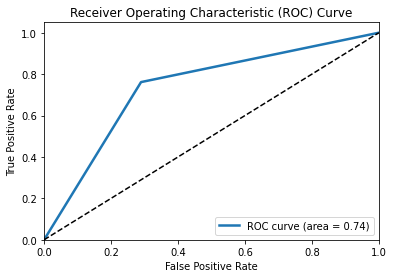

In [ ]:
# display the model performance matrics and plot ROC curve for model1
predictions = num2class_label_transformer(predict_nn1)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions,
                                      classes=list(set(test_labels)))

plot_model_roc_curve(first_cnn, test_imgs_scaled,
                         true_labels=test_labels_enc,
                         class_names=[0, 1], 
                         pred_probs=predict_nn1)

b) Basic CNN Performance

Model Performance metrics:
------------------------------
Accuracy: 0.7528
Precision: 0.7528
Recall: 0.7528
F1 Score: 0.7528

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.75      0.76      0.75      1426
         cat       0.76      0.75      0.75      1450

    accuracy                           0.75      2876
   macro avg       0.75      0.75      0.75      2876
weighted avg       0.75      0.75      0.75      2876


Prediction Confusion Matrix:
------------------------------
            Predicted:      
                   dog   cat
Actual: dog  1078       348 
        cat  363        1087


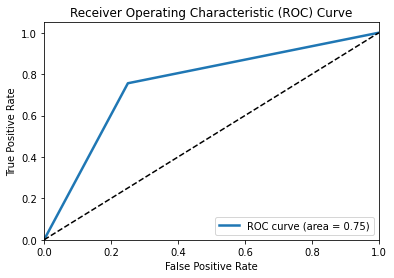

In [ ]:
# display the model performance matrics and plot ROC curve for model2
predictions = num2class_label_transformer(predict_nn2)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions,
                                      classes=list(set(test_labels)))

plot_model_roc_curve(basic_cnn, test_imgs_scaled,
                         true_labels=test_labels_enc,
                         class_names=[0, 1], pred_probs=predict_nn2)

c) Basic CNN with Image Augmentation Performance

Model Performance metrics:
------------------------------
Accuracy: 0.8241
Precision: 0.8316
Recall: 0.8241
F1 Score: 0.8229

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.88      0.75      0.81      1426
         cat       0.78      0.90      0.84      1450

    accuracy                           0.82      2876
   macro avg       0.83      0.82      0.82      2876
weighted avg       0.83      0.82      0.82      2876


Prediction Confusion Matrix:
------------------------------
            Predicted:      
                   dog   cat
Actual: dog       1063   363
        cat        143  1307


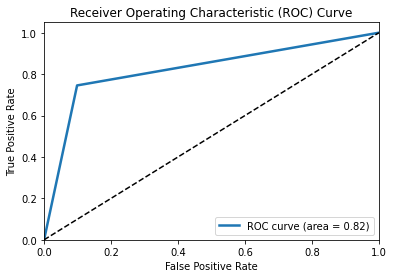

In [ ]:
# display the model performance matrics and plot ROC curve for model3
predictions = num2class_label_transformer(predict_nn3)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions,
                                      classes=list(set(test_labels)))

plot_model_roc_curve(img_aug_cnn, test_imgs_scaled,
                         true_labels=test_labels_enc,
                         class_names=[0, 1], pred_probs=predict_nn3)

d) Pre-trained CNN as a Feature Extractor Performance

Model Performance metrics:
------------------------------
Accuracy: 0.8244
Precision: 0.8635
Recall: 0.8244
F1 Score: 0.8193

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.98      0.66      0.79      1426
         cat       0.75      0.99      0.85      1450

    accuracy                           0.82      2876
   macro avg       0.86      0.82      0.82      2876
weighted avg       0.86      0.82      0.82      2876


Prediction Confusion Matrix:
------------------------------
            Predicted:      
                   dog   cat
Actual: dog  937        489 
        cat  16         1434


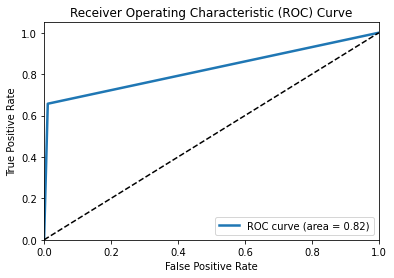

In [ ]:
# display the model performance matrics and plot ROC curve for model4
predictions = num2class_label_transformer(predict_nn4)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions,
                                      classes=list(set(test_labels)))

plot_model_roc_curve(tl_cnn, test_imgs_scaled,
                         true_labels=test_labels_enc,
                         class_names=[0, 1], pred_probs=predict_nn4)

e) Pre-trained CNN as a Feature Extractor with Image Augmentation Performance

Model Performance metrics:
------------------------------
Accuracy: 0.9138
Precision: 0.914
Recall: 0.9138
F1 Score: 0.9138

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.90      0.93      0.91      1426
         cat       0.93      0.90      0.91      1450

    accuracy                           0.91      2876
   macro avg       0.91      0.91      0.91      2876
weighted avg       0.91      0.91      0.91      2876


Prediction Confusion Matrix:
------------------------------
            Predicted:      
                   dog   cat
Actual: dog       1320   106
        cat        142  1308


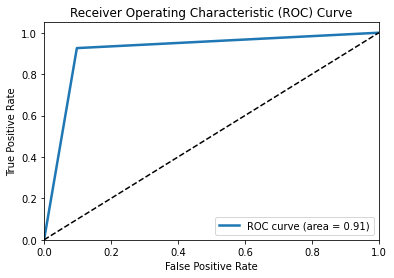

In [ ]:
# display the model performance matrics and plot ROC curve for model5
predictions = num2class_label_transformer(predict_nn5)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions,
                                      classes=list(set(test_labels)))

plot_model_roc_curve(tl_img_aug_cnn, test_imgs_scaled,
                         true_labels=test_labels_enc,
                         class_names=[0, 1], pred_probs=predict_nn5)

f) Pre-trained CNN with Fine-tuning and Image Augmentation Performance

Model Performance metrics:
------------------------------
Accuracy: 0.9513
Precision: 0.9537
Recall: 0.9513
F1 Score: 0.9513

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.92      0.99      0.95      1426
         cat       0.99      0.92      0.95      1450

    accuracy                           0.95      2876
   macro avg       0.95      0.95      0.95      2876
weighted avg       0.95      0.95      0.95      2876


Prediction Confusion Matrix:
------------------------------
            Predicted:      
                   dog   cat
Actual: dog       1408    18
        cat        122  1328


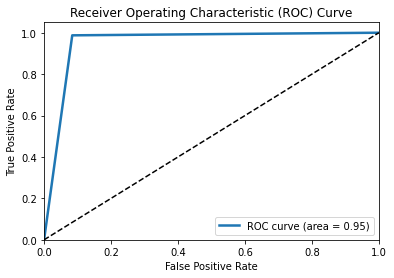

In [ ]:
# display the model performance matrics and plot ROC curve for model6
predictions = num2class_label_transformer(predict_nn6)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions,
                                      classes=list(set(test_labels)))

plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled,
                         true_labels=test_labels_enc,
                         class_names=[0, 1], pred_probs=predict_nn6)